<img src = "../image/cover.png" alt = "cover"/>

[*source*](https://earlygame.com/uploads/images/_body/nfs-reveal-week-14.jpg)


---

# Contents  

## [Part 1 (The Data Science Problem)](#part1)
### [1.1 Overview](#overview)
- #### [1.1.1 Background Information](#backgroundinformation)
- #### [1.1.2 Problem Statement](#problemstatement)
- #### [1.1.3 Method(ology)](#methodology)

### [1.2 Data Collection](#datacollection)  
- #### [1.2.1 Pedestrian Kaggle Dataset](#pedkaggle)
- #### [1.2.2 Recorded Images/Videos](#rec)

### [1.3 Exploratory Data Analysis (EDA)](#eda)  
- #### [1.3.1 Verify Labels](#verifylabels)
- #### [1.3.2 Check Class Imbalance](#checkclassimbalance)
- #### [1.3.3 Plot Image Dimensions](#plotimagedimensions)

### [1.4 Data Visualization](#datavisualization)
- #### [1.4.1 Image Detection](#imagedetection)  
- #### [1.4.2 Video Detection](#videodetection)  

### [Summary](#p1sum)

## Part 2 (Image Classification - see Notebook 2)    

## Part 3 (Object Detection - see Notebook 3)  
---

<div id="part1"></div>

## Part 1 (The Data Science Problem)

The first notebook strives to establish the data science problem, which includes providing an overview of the topic on hand and define the problem statement. After which, EDA and visualization of the collected data(sets) are conducted. 


<div id="overview"></div>

### 1.1 Overview

The turn of the century has witnessed a pivotal urban/rural shift: more than half of the world's population now live in cities, with the figure expected to increase to ~70% by 2050 ([*UN World Urbanization Prospects Report, 2014*](https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/files/documents/2020/Oct/unpd_2014_wup-report.pdf)). Concomitantly, there is an unprecedented pressure on transportation resources and infrastructure, which governments actively endeavour to alleviate. Traditionally, transport researches relied on manual travel research conducted on board, at stops or stations, or at the household level. However, [*Iliashenko et al., (2021)*](https://www.sciencedirect.com/science/article/pii/S2352146521003240) postulates that the data revolution - especially harnessing Big Data ([*Thakuriah et al., 2016*](https://link.springer.com/book/10.1007/978-3-319-40902-3)) - has unlocked new possibilities for transport modelling and solutions. While advanced transport planning is a wide nascent field, the project focusses on technologies for unmanned vehicles and the organization of interaction between road users. 


<div id="backgroundinformation"></div>

#### 1.1.1 Background Information

<img src = "../image/hyundai.png" alt = "hyundai_sg"/>

*Fig. 1 Illustration of Hyundai's (upcoming) EV Plant in SIngapore* ([*source*](https://www.automotivelogistics.media/electric-vehicles/hyundai-to-build-randd-centre-and-factory-in-singapore/41179.article))

Singapore is no exception to this trend. The Land Transport Authority (LTA) - a statutory board under the Ministry of Transport overseeing Singapore's transport planning, development and systems - has inaugurated [*Intelligent Transport Systems (ITS)*](https://www.lta.gov.sg/content/ltagov/en/getting_around/driving_in_singapore/intelligent_transport_systems.html), which constitute web of data collection via gadgets, sensors and cameras to forms dynamic, real-time representations depicting the ebb and flow of everyday life in Singapore. ITS utilizes data analytics, traffic and control systems to maximise road network efficiency capacity, monitor and manage traffic flow. The [*ongoing development of Hyundai's Electric-Vehicle (EV) Plant*](https://www.automotivelogistics.media/electric-vehicles/hyundai-to-build-randd-centre-and-factory-in-singapore/41179.article) in Jurong Innovation District speaks volumes of the state's efforts on growing the subject industry locally. The facility will primarily focus on new technologies (e.g. AI, big data, autonomous vehicles, urban air mobility) and contain a small scale EV production function, which is projected to produce 30,000 cars by 2025. Since the [*arrival of Tesla in Singapore*](https://www.reuters.com/business/autos-transportation/tesla-ev-sales-boom-singapore-pushing-rivals-models-off-streets-2021-10-28/) in Jul 2021, the exponential growth in popularity of the "Apple-like" automobile brand in Singapore is arguably biggest testimony to the direction smart vehicles are steered towards in the near future. With this context in place, we explore the role of data science in smart vehicle technologies. 



<div id="problemstatement"></div>

#### 1.1.2 Problem Statement

<img src = "../image/cetran.png" alt = "cetran"/>

*Fig. 2 CETRAN Test Circuit* ([*source*](https://landtransportguru.net/volvo-7900-electric/cetran-circuit/))


as the members of the data science group for the Centre of Excellence for Testing & Research of Autonomous Vehicles - NTU ([*CETRAN*](https://cetran.sg/)), the team has been assigned with the following two-prong task aimed at identifying pedestrians in urban environments:  

(i) Develop an image classification model to determine whether there are pedestrian(s) in a given image; and  
(ii) Develop an object detection model to identify and spatially indicate pedestrian(s) in a given image or video, if any. 

The model should be sufficiently adaptable to operate under both day and night conditions. The results will guide the implementation of anti-collision technologies as part of CETRAN's autonomous vehicle testing.  

**CETRAN is a joint collaboration between Nanyang Technological University (NTU), LTA and Jurong Town Corporation (JTC), focussing on generating fundamental research on AV systems, developing testing requirements, and establishing internal standards for autonomous vehicles.*


<div id="methodology"></div>

#### 1.1.3 Method(ology)

##### Libraries Used 

In [1]:
# General Modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import glob
import win32gui, win32ui, win32con, win32api
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, f1_score

# Image Processing Modules
import cv2
import imutils
import matplotlib.image as mpimg
from PIL import ImageGrab
from IPython.display import Image, clear_output  

# Modelling (CNN) Modules
import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


##### Model Framework

The production models will be developed in two-steps:  

                           Predicted variable (y): 1 = Person | 0 = Not Person

    a) Image Classification - An image classification model will first be built using convolutional neural network (CNN) to predict whether a given image depicts a person or otherwise. To ensure production modelling is holistic, we consider a varied set of possible models ranging from built-from-scratch CNN models to pre-trained CNN models (VGG16, ResNet50). Also, model parameters will be tuned and regularized to optimize performance. The CNN models will be trained on the Kaggle pedestrian dataset. 
    
    b) Objection Detection - After which, given the highly complex nature of object detection models, we will be borrowing two popular pre-built models, particularly Darknet + YOLOv4 and PyTorch + YOLOv5. The latter will likewise be trained on the Kaggle pedestrian dataset.  



##### Scoring Metrics

For model performance evaluation, we consider the following scoring metrics sequentially for the image classification models built on CNN as the underlying foundation, each with their respective thresholds: 

    i) Accuracy [(TP + TN) / (TP + FP + TN + FN)] - First, we review accuracy as the most fundamental indicator, which gives the ratio of correct predictions to total predictions. However, accuracy per se is inadequate as it does not inform on model effectiveness and precision, not to mention that it can be artificially tweaked by adjusting the threshold to achieve a biased outcome. Given that the margin for error is extremely low as it would likely lead to accidents, we set a benchmark of 90% for accuracy. 
    
    ii) Loss (Binary Cross-entropy: Negative average of the log of corrected predicted probabilities.) - Next, we consider binary cross-entropy as the loss function, which measures the performance of a model based on the difference between the predicted probabilities (between 0 and 1) and actual class output (either 0 or 1). In some sense, the loss function is a better proxy of a model's predictive power relative to accuracy as it takes into account the difference margin between predictions and observed outputs while the latter only counts the number of right/wrong predictions. Given that binary cross-entropy results are log values, it is difficult to establish an evaluate benchmark. Thus, we will assess it relatively across models in striving to minimize loss.  

    iii) Sensitivity [TP / (TP + FN)] - For this study, false negatives (i.e. model fails to predict an object as a person when in reality, the object is a person) are relatively intolerable as it would result in fatal car accidents. Hence, sensitivity will be considered too which seeks to minimize false negatives, at an established threshold of 80%. 
    
    iv) F1-score [2 * (Precision * Recall) / (Precision + Recall)]; Precision = [TP / (TP + FP)]; Recall = [TP / (TP + FN)] - Defined as the harmonic mean of precision and recall, the former is a measure of accuracy of positive values predicted while the latter is a proxy of true positives successfully captured by the model. Putting both together, the F1-score provides a sense of confidence in a model's predicted positive values. In this case, while false positives are relatively less prioritized, it is still essential to minimize it where possible as excessive false positives translates to the model repeatedly identifying objects as persons when it is not reality. Resultantly, if implemented in self-driving cars, vehicles would frequently make unnecessary brakes due to the incorrect interpretation of objects as persons. For F1-score, a benchmark of 80% is set. 

Further, for object detection models, we consider an additional metric:

    v) Mean Average Precision (mAP) - The mean of average precisions for all classes at a given intersection over union (IoU - typically 0.5), which is also represented by the area under the precision-recall curve. The rationale for examining the mAP is that it is considered as the most comprehensive metric for CV and object detection models, as it not only takes into account various IoU thresholds but all classes as well, thereby ensuring the same basis for comparison across different models. Since this is the sole metric analyzed, a stricter benchmark of 90% is adopted. 
    
    

*TP = True Positive (Object identified as a person and indeed object is a person)*  
*TN = True Negative (Object not identified as a person and indeed object is not a person)*  
*FP = False Positive (Object identified as a person but object is not a person in reality)*  
*FN = False Negative (Object not identified as a person but object is a person in reality)*  


<div id="datacollection"></div>

### 1.2 Data Collection

This section broadly covers the datasets used; this includes the types of data, their origins, and the motivations for selecting the data. Also, given that only minor data cleaning is required for the project, it will be incorporated in this section as well. 


<div id="pedkaggle"></div>

#### 1.2.1 Pedestrian Kaggle Dataset

For the purposes of training the image classification model, we borrow the [*Kaggle pedestrian dataset*](https://www.kaggle.com/karthika95/pedestrian-detection) authored by Karthika & Saravanan (2020). The structure of the dataset is as per the directory tree below; the dataset is conveniently split into train, test and validation sets, of which each contains two folders storing the images and accompanying annotations respectively. Given this, train-test split will not be required during modelling stage, and the test set will form the "blind" holdout set. The images constitute person and person-like objects (PnPLO). Person objects depict actual people while Person-like objects include statues, mannequins, scarecrows and robots. The intention is to reduce false positives by training the model not only on images of people but on objects with similar features to humans. If a model is trained on a dataset only containing persons, it would lead to several false positives since it cannot differentiate such objects from that of a person. The 'ground truth' labels (i.e. whether image contains a person or person-like object) are stated accordingly in the annotations. 


In [2]:
for root, dirs, files in os.walk("../data/kaggle_raw"):
    level = root.replace("../data/kaggle_raw", '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    ## codes below commented out to freeze printing for directory files to prevent extensive print results
    ## for full folder directory listing, uncomment codes below and rerun list_files function
    #for f in files: 
        #print('{}{}'.format(subindent, f))
            

kaggle_raw/
    Test/
        Annotations/
        JPEGImages/
    Train/
        Annotations/
        JPEGImages/
    Val/
        Annotations/
        JPEGImages/


However, as the datasets will be imported via keras' ImageDataGenerator for ease of loading prior to modelling, the folders will be manually reorganized at the backend based on classes, as per the requirement of said function. To verify reorganization is successful: 


In [3]:
for root, dirs, files in os.walk("../data/kaggle_sorted"):
    level = root.replace("../data/kaggle_sorted", '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    

kaggle_sorted/
    test/
        not_person/
        person/
    train/
        not_person/
        person/
    val/
        not_person/
        person/


<div id="rec"></div>

#### 1.2.2 Recorded Images/Videos

Apart from the Kaggle pedestrian dataset, recorded videos of two locations in Singapore (NTU, Orchard Road) extracted from YouTube will also be used as 'holdout data' to assess both the image classification and object detection production models. Afterall, the primary application of the models is pedestrian classification/detection for autonomous vehicles in a (real) urban environment. Generally, the videos (each 2-4mins) is split according to location and day/night:  
- NTU ([*source*](https://www.youtube.com/watch?v=4bVYgAtkyCU)) - Given that CETRAN is driven by NTU in collaboration with supporting government agencies, NTU forms a natural testbed for self-driving vehicles. Numerous signages placed around NTU (at the point of writing), stating that autonomous vehicle testing is going. It is not entirely uncommon for universities to be employed as testing grounds for various projects, in part attributed to the academic and developmental nature of universities. Specifically in the case of pedestrian classification/detection, NTU is an ideal starting point to test the models as there is a constant flow of students/staffs throughout the campus and "noises" in the form of roadside elements are fairly minimal.   
- Orchard Road (Day) ([*source*](https://www.youtube.com/watch?v=4Wi8TqxB_28)) - Moving on, the project strives to push the production models to the limit by testing in Orchard Road, Singapore's key shopping district. Needless to say, Orchard Road is characterized by high footfall not only at traffic junctions but along roadsides as well. Further, "noises" (e.g. advertisements, large monitor panels, decorative structures) are extensive too, which would prove meaningful albeit challenging when examining the predictive power of models.  
- Orchard Road (Night) ([*source*](https://www.youtube.com/watch?v=QnvkAAOOc1U)) - Without significant changes made to the route for Orchard Road in a bid to maintain consistency, the production models are tested under night time conditions to ascertain if model performance deviates.  

For the abovementioned videos, 4 frames will be extracted as pictures from each video respectively, to be used for image processing. The total of 12 images are printed below for reference: 


In [4]:
# Create custom function to print image
def display_image(path):
    plt.figure()
    image = mpimg.imread(path)
    plt.imshow(image) 
    plt.show()


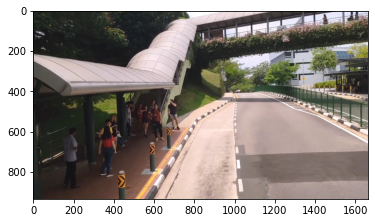

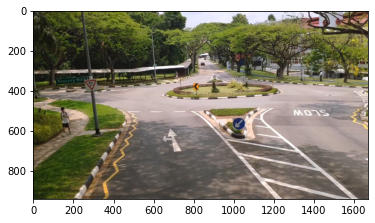

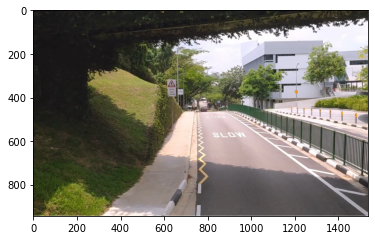

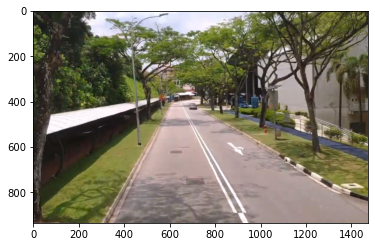

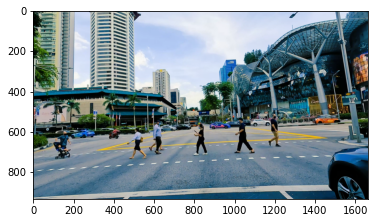

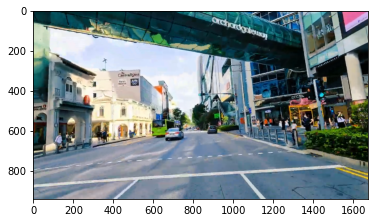

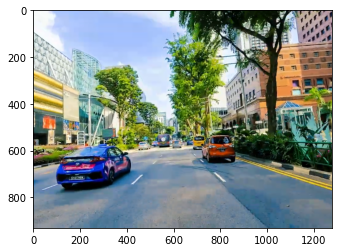

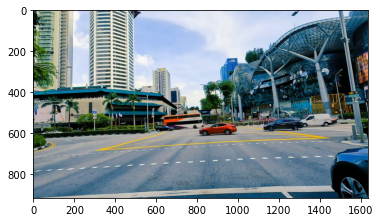

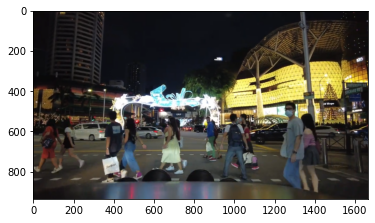

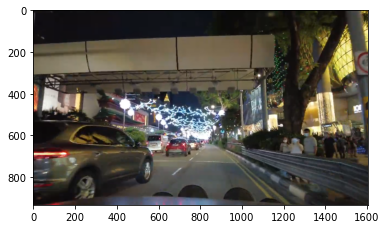

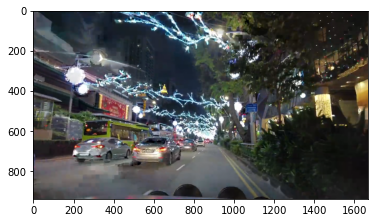

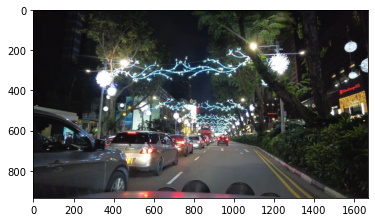

In [5]:
display_image("../data/recorded/ntu1.png") # NTU1 - pedestrians
display_image("../data/recorded/ntu2.png") # NTU2 - pedestrians
display_image("../data/recorded/ntu3.png") # NTU3 - no pedestrians
display_image("../data/recorded/ntu4.png") # NTU4 - no pedestrians
display_image("../data/recorded/orchard_day1.png") # orchard_day1 - pedestrians
display_image("../data/recorded/orchard_day2.png") # orchard_day2 - pedestrians
display_image("../data/recorded/orchard_day3.png") # orchard_day3 - no pedestrians 
display_image("../data/recorded/orchard_day4.png") # orchard_day4 - no pedestrians
display_image("../data/recorded/orchard_night1.png") # orchard_night1 - pedestrians
display_image("../data/recorded/orchard_night2.png") # orchard_night2 - pedestrians
display_image("../data/recorded/orchard_night3.png") # orchard_night3 - no pedestrians
display_image("../data/recorded/orchard_night4.png") # orchard_night4 - no pedestrians


<div id="eda"></div>

### 1.3 Exploratory Data Analysis (EDA)

EDA will commence with a preliminary inspection of the dataset by viewing sample images of person and non-person objects from the train set, followed by verifying the accompanying labels to ensure images are sorted correctly. Next, we check the ratio of person to non-person images for all sets and conclude with plotting image dimensions. 


<div id="verifylabels"></div>

#### 1.3.1 Verify Labels


In [6]:
# Define classes (person-like vs person) and labels (0 vs 1)
class_names = ['person-like', 'person']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

# Create custom function to load sets
def load_data():
    datasets = ['../data/kaggle_raw/Train', '../data/kaggle_raw/Test', '../data/kaggle_raw/Val']
    output = []

    for dataset in datasets:
        images = []
        labels = []
        directoryA = dataset +"/Annotations"
        directoryIMG = dataset +"/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:

            xmlf = os.path.join(directoryA,xml)
            dom = ET.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            images.append(curr_img)
            i +=1
        
        #images = np.array(images, dtype='float32')
        #images = images / 255
        
        #labels = np.array(labels, dtype='int32')

        output.append((images, labels))
    return output


In [7]:
# Load in original train, test and validation sets for EDA
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_data()


In [8]:
# Checking the train set: 
X_train
## Images successfully imported in np.array format


[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [248, 205, 202],
         [249, 206, 203],
         [250, 207, 204]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [249, 206, 203],
         [249, 206, 203],
         [248, 205, 202]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [252, 209, 206],
         [251, 208, 205],
         [251, 208, 205]],
 
        ...,
 
        [[178, 191, 205],
         [167, 180, 194],
         [179, 192, 206],
         ...,
         [119, 128, 137],
         [101, 112, 120],
         [101, 113, 119]],
 
        [[165, 178, 192],
         [166, 179, 193],
         [166, 179, 193],
         ...,
         [100, 106, 111],
         [ 97, 103, 108],
         [110, 119, 122]],
 
        [[151, 164, 178],
         [153, 166, 180],
         [158, 171, 185],
         ...,
         [ 73,  77,  82],
  

In [9]:
# Checking the train set labels: 
print(y_train)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [10]:
# Create custom function to print image
def display_image(path):
    plt.figure()
    image = mpimg.imread(path)
    plt.imshow(image) 
    plt.show()
    

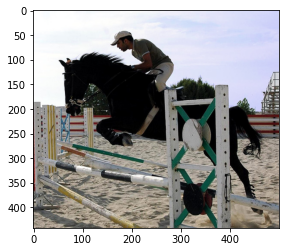

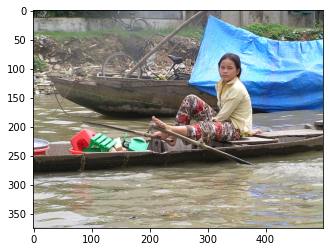

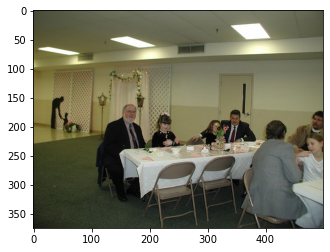

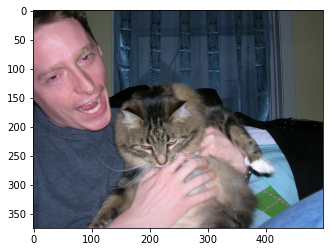

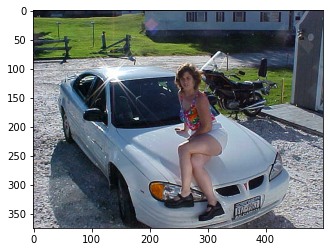

In [11]:
# View sample of first 5 images in train set
display_image("../data/kaggle_raw/Train/JPEGImages/image (1).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (2).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (3).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (4).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (5).jpg")


Comparing the first 5 images in the train set against their respective labels indicated by the first 5 values in y_train (i.e. 1, 1, 1, 1, 1), these images are correctly labelled as they contain person objects. 


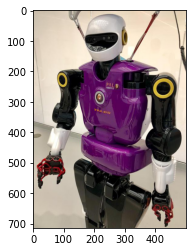

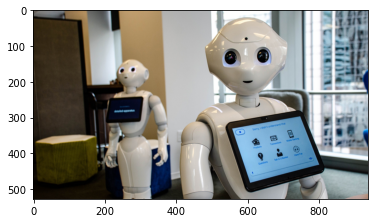

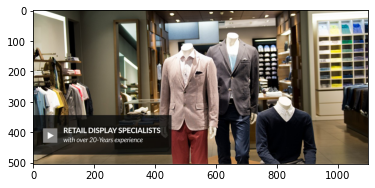

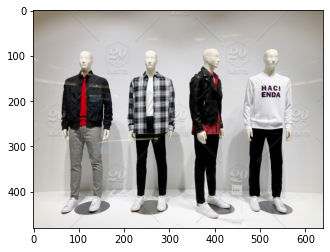

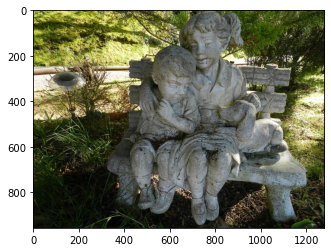

In [12]:
# View sample of last 5 images in train set
display_image("../data/kaggle_raw/Train/JPEGImages/image (940).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (941).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (942).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (943).jpg")
display_image("../data/kaggle_raw/Train/JPEGImages/image (944).jpg")


On the contrary, the last 5 images in the train set do not correspond with the last 5 values in y_train (i.e. 1, 1, 1, 1, 1) as said images contain non-person objects (e.g. statues, mannequins, robots). Thus, given that there are wrongly classified images in the original dataset, a manual verification for all images (i.e. in train, test and val sets) is performed and resorted accordingly in the respective folders. For clarity, in the event an image contains both person and non-person objects, the image will be labelled as a person image (1). The rationale is to ensure the model is as encompassing as possible, to reduce the extent of false negatives which translates to higher incidences of accidences upon implementation. 


<div id="checkclassimbalance"></div>

#### 1.3.2 Check Class Imbalance

Following which, we check the sets to ensure that the images classes are not heavily skewed after resorting is completed: 


In [13]:
# Checking image count after resorting
def count_files(dirs, class_type, folder_name):
    count = 0
    for path in os.listdir(dirs):
        if os.path.isfile(os.path.join(dirs, path)):
            count += 1
    print("There are " + str(count) + " " + class_type + " images in the " + folder_name + " set.")


In [14]:
count_files("../data/kaggle_sorted/train/person", "Person", "Train")
count_files("../data/kaggle_sorted/train/not_person", "Non-Person", "Train")


There are 558 Person images in the Train set.
There are 386 Non-Person images in the Train set.


In [15]:
count_files("../data/kaggle_sorted/test/person", "Person", "Test")
count_files("../data/kaggle_sorted/test/not_person", "Non-Person", "Test")


There are 156 Person images in the Test set.
There are 79 Non-Person images in the Test set.


In [16]:
count_files("../data/kaggle_sorted/val/person", "Person", "Validation")
count_files("../data/kaggle_sorted/val/not_person", "Non-Person", "Validation")


There are 90 Person images in the Validation set.
There are 70 Non-Person images in the Validation set.


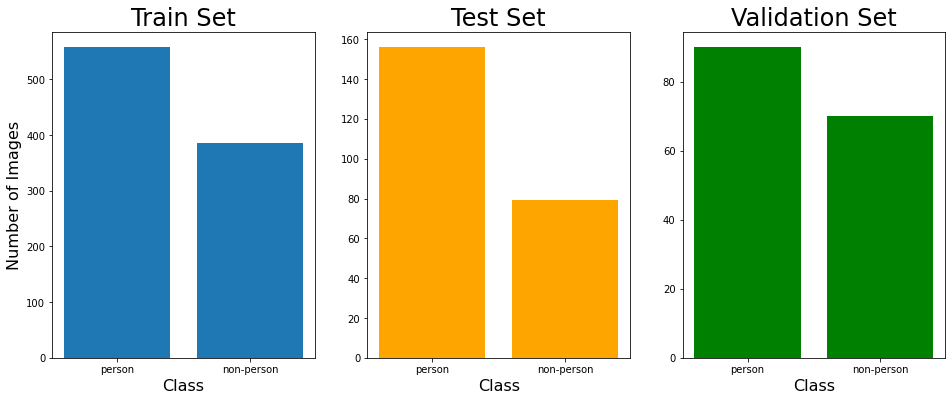

In [17]:
# Visualizing class imbalance using bar graphs
classes = ['person', 'non-person']

train = [558, 386]
test = [156, 79]
val = [90, 70]

fig = plt.figure(figsize = (16, 6))

ax0 = plt.subplot(1, 3, 1)
plt.bar(classes, train)
plt.xlabel("Class", size = 16)
plt.ylabel("Number of Images", size = 16)
plt.title("Train Set", size = 24) 

ax1 = plt.subplot(1, 3, 2)
plt.bar(classes, test, color = 'orange')
plt.xlabel("Class", size = 16)
plt.title("Test Set", size = 24) 

ax2 = plt.subplot(1, 3, 3)
plt.bar(classes, val, color = 'green')
plt.xlabel("Class", size = 16)
plt.title("Validation Set", size = 24) 

plt.show()


Based on calculation, across all sets, person images constitute about 55%-65% while non-person images account for the remaining 35-45%. Given that the proportion is not too heavily skewed, no further processing is required at this stage. 


<div id="plotimagedimensions"></div>

#### 1.3.3 Plot Image Dimensions

Lastly, the image dimensions are plotted to assess the distribution of image widths x heights across all datasets. From the cell below which returns the dimensions of the first and last 3 images in the train dataset, we confirm that the image dimensions vary. 


In [18]:
# First 3 train images
print(X_train[0].shape[0:2])
print(X_train[1].shape[0:2])
print(X_train[2].shape[0:2])
# Last 3 train images
print(X_train[941].shape[0:2])
print(X_train[942].shape[0:2])
print(X_train[943].shape[0:2])


(442, 500)
(332, 500)
(374, 500)
(375, 500)
(288, 384)
(450, 375)


In [19]:
# Create custom function to save image dimensions for different datasets in a list format 
def get_dimensions(dataset):
    dimensions = []
    for image in dataset:
        dimensions.append(image.shape[0:2])
    return dimensions


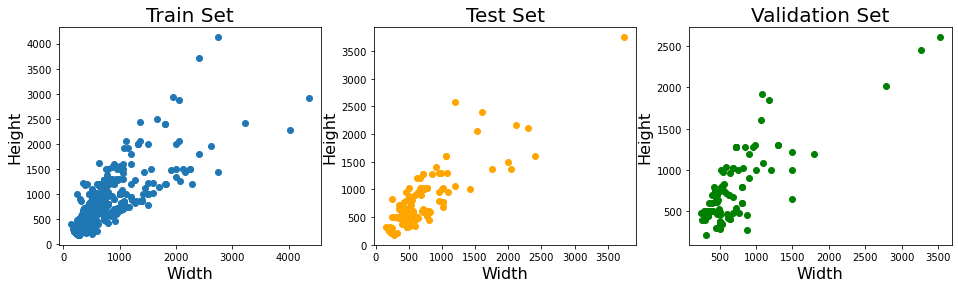

In [20]:
# Visualizing distribution of image dimensions using scatterplots
fig = plt.figure(figsize = (16, 4))

ax0 = plt.subplot(1, 3, 1)
plt.scatter(*zip(*get_dimensions(X_train)))
plt.xlabel("Width", size = 16)
plt.ylabel("Height", size = 16)
plt.title("Train Set", size = 20) 

ax1 = plt.subplot(1, 3, 2)
plt.scatter(*zip(*get_dimensions(X_test)), c = 'orange')
plt.xlabel("Width", size = 16)
plt.ylabel("Height", size = 16)
plt.title("Test Set", size = 20) 

ax2 = plt.subplot(1, 3, 3)
plt.scatter(*zip(*get_dimensions(X_val)), c = 'green')
plt.xlabel("Width", size = 16)
plt.ylabel("Height", size = 16)
plt.title("Validation Set", size = 20) 

plt.show()


As shown in the scatter plots above, image dimensions across the sets are varied, with most images being in the range of 500x500 to 1,000x1,000 pixcels, although there are a number of outliers which increase up to 4,000x4,000. Hence, rescaling of images to standardize dimensions will be carried out at the preprocessing stage subsequently. 


<div id="datavisualization"></div>

### 1.4 Data Visualization
  
The final section on data visualization attempts to conduct object detection on sample images/videos from the datasets using OpenCV's traditional [*Histogram of Oriented Gradient (HOG)*](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)  Descriptor by (Dalal & Triggs, 2005) combined with Support Vector Machine (SVM). Compiling inputs from various sources, we seek to understand HOG by breaking the concept down into constituent terms and study them systematically from 'gradients' to 'oriented' and finally to 'histogram'. HOG is a feature descriptor, a simplified representation of an image which serves for easy identification by containing only the most critical information about the image (namely its edges) while removing "extra" elements.  

a) Gradient: After the necessary preprocessing to the required scale, the x-gradient (left to right) and y-gradient (top to bottom) is calculated for every pixel in the image. Both gradients are consolidated into a single gradient value using the formula sqroot(x-gradient^2 + y-gradient^2), which forms the total gradient magnitude for a given pixel. Naturally, the gradients are largest where there are significant changes in color (black (0) to white (255) being the most extreme) at boundary edges.  

b) Oriented: Next, using the original x-gradients and y-gradients, the gradient direction is calculated using the formula tan^(-1)(y-gradient / x-gradient), which forms the gradient orientation for the same given pixel.  

c) Histogram: Instead of plotting histograms showing the frequency distribution of gradient magnitudes and orientation for every pixel in the image, a more compact histogram of gradients is computed by passing an n by n (e.g. 8x8) layer over the image. Each n by n patch contains both the gradient magitude as well as orientation. Then, the 9-bin histogram of gradients is constructed using orientation intervals as bins (0, 20, 40, 60, 80, 120, 140, 160) and magnitude as frequency (a more detailed explanation of the math is found [*here*](https://learnopencv.com/histogram-of-oriented-gradients/)). 

Lastly, the histograms are normalized by running larger m by m patches (where m > n) across the image and concatenated thereafter into a single large vector represented by a large array of numbers graphically. At this point, SVM is selected as an image classifier to predict whether a person is present or otherwise. 


In [21]:
# Initializing the HOG person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector()) # Feed HOG person detector into SVM classifier

# Credits for HOG source code: 
 # https://thedatafrog.com/en/articles/human-detection-video/
 # https://data-flair.training/blogs/python-project-real-time-human-detection-counting/


<div id="imagedetection"></div>

#### 1.4.1 Image Detection  

In [22]:
# Create custom function to parse image into HOG people detector
def hog_image(image_path): 
    image = cv2.imread(image_path) # Load image from specified file path
    image = imutils.resize(image, width = min(800, image.shape[1])) 
    (regions, _) = hog.detectMultiScale(image, winStride = (4, 4), padding = (4, 4), scale = 1.05) 
    # Explaining choice of hog.detectMultiScale parameters:
    # detectMultiScale function Detects objects of different sizes in the input image and returned as a list of rectangles
     # image = image parsed into HOG detector; self-explanatory
     # winStride = 2-tuple that dictates the “step size” in both the x and y location of the sliding window
      # Significantly influences the accuracy as well as speed of detection, where there is a trade-off between both
       # Smaller winStride = more windows to evaluate = higher accuracy + lower speed
       # Bigger winStride = less windows to evaluate = lower accuracy + higher speed
      # We adopt winStride = (4, 4) as advised by online sources
     # padding = tuple which indicates the number of pixels in both x and y direction in which the sliding window is “padded”
     # scale = defines the factor by which the image is resized at each layer of an image pyramid; 
      # determines number of layers in image pyramid
       # Smaller scale = higher number of layers = higher accuracy + lower speed
       # Bigger scale = lower number of layers = lower accuracy + higher speed
      # We adopt scale = 1.05 as advised by online sources
    # detectMultiScale function returns a list of rectangles of all the person objects in the input image
     # list contains tuples, (x, y, w, h), where the x, y values represent the top-left coordinates of the rectangle, 
      # while the w, h values represent the width and height of the rectangle
    for (x, y, w, h) in regions: # Values as taken from detectMultiScale above
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2) # Parameters: (image, start_point, end_point, color, thickness)
    cv2.imshow("Image", image) # Show image with detection rectangles superimposed over
    cv2.waitKey(0) # Set key to quit image window
    cv2.destroyAllWindows()

# Credits for 
 # https://pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
 # https://debuggercafe.com/opencv-hog-hyperparameter-tuning-for-accurate-and-fast-person-detection/
 # https://stackabuse.com/facial-detection-in-python-with-opencv/


We test the HOG detector on the first and last 3 images containing person(s) in the train set: 


In [23]:
# Run first 3 person images in train set into HOG detector
hog_image('../data/kaggle_sorted/train/person/image (1).jpg')
hog_image('../data/kaggle_sorted/train/person/image (2).jpg')
hog_image('../data/kaggle_sorted/train/person/image (3).jpg')
# Run last 3 person images in train set into HOG detector
hog_image('../data/kaggle_sorted/train/person/image (924).jpg')
hog_image('../data/kaggle_sorted/train/person/image (931).jpg')
hog_image('../data/kaggle_sorted/train/person/image (935).jpg')

## Results printed below for ease of reference


<img src = "../image/hog_persons.png" alt = "hog_persons"/>

*Fig. 3 HOG People Detector on Images with Persons*

Evaluating the HOG People Detector performance on images containing person object(s): 
- Image (1): Failed to identify the person on the horse, likely due to the side-angled front-bending posture of the rider  
- Image (2): Failed to identify the person on the boat, likely due to the sitting person of the individual  
- Image (3): Only identified the man in black suit while missing out on everyone else in the frame; wrongly identified the wedding arch behind as a person  
- Image (924): Wrongly identified the left-arm of the sole individual as a person 
- Image (931): Wrongly ientified various parts of the sole individual as persons
- Image (935): Identified the woman in the image as a person (albeit only partially) but wrongly identified many other elements as persons

Doubtless, the HOG People Detector performed poorly on the sample images containing person object(s). Not only did the algorithm miss out on many actual persons (low True Positive and high False Negative), but it falsely classified many other parts/elements in the image as persons (high False Positive). 

For comparison, we similarly run the HOG detector on the first and last 3 images containing non-person(s) in the train set:


In [24]:
# Run first 3 non-person images in train set into HOG detector
hog_image('../data/kaggle_sorted/train/not_person/image (527).jpg')
hog_image('../data/kaggle_sorted/train/not_person/image (528).jpg')
hog_image('../data/kaggle_sorted/train/not_person/image (529).jpg')
# Run last 3 non-person images in train set into HOG detector
hog_image('../data/kaggle_sorted/train/not_person/image (942).jpg')
hog_image('../data/kaggle_sorted/train/not_person/image (943).jpg')
hog_image('../data/kaggle_sorted/train/not_person/image (944).jpg')

## Results printed below for ease of reference


<img src = "../image/hog_non_persons.png" alt = "hog_non_persons"/>

*Fig. 4 HOG People Detector on Images with Non-Persons*


Evaluating the HOG People Detector performance on images containing non-person object(s): 
- Image (527): Wrongly identified various parts of the image as persons  
- Image (528): No issues as detector did not identify any parts of the image (including human-like statues) as persons  
- Image (529): Wrongly identified the sole statue as a person; likely due to the standing posture of statue, of which the edges are accentuated by the color gradient from light (statue) to darker (sky)  
- Image (942): Wrongly identified various parts of the image as persons  
- Image (943): Wrongly identified selected status as persons; likely due to the standing posture of the statues     
- Image (944): No issues as detector did not identify any parts of the image (including human-like statues) as persons  

Again, the abovementioned loopholes in the HOG People Detector are apparent when tested on images containing non-persons. An additional takeaway is that the object structure (i.e. posture of (non-)person objects) matters; non-person objects in a standing disposition will likely be falsely identified as persons when passed through the HOG People Detector.  


<div id="videodetection"></div>

#### 1.4.2 Video Detection  

In [25]:
# Create custom function to parse image into HOG people detector
def hog_video(video_path): 
    cap = cv2.VideoCapture(video_path) # Load video from specified file path
    while cap.isOpened(): # Read the video stream
        ret, image = cap.read() 
        if ret:
            image = imutils.resize(image, width = min(800, image.shape[1]))
            (regions, _) = hog.detectMultiScale(image, winStride = (8, 8), padding = (4, 4), scale = 1.05) 
            # winStride changed to (8, 8) to allow for smoother video playback at the expense of accuracy
            for (x, y, w, h) in regions:
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.imshow("Video", image)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    cv2.destroyAllWindows()


The HOG People Detector is tested on the recorded videos: 

In [26]:
hog_video("../data/recorded/ntu.mp4")
hog_video("../data/recorded/orchard_day.mp4")
hog_video("../data/recorded/orchard_night.mp4")
# Sample frames printed below


<img src = "../image/hog_vid.png" alt = "hog_vid"/>

*Fig. 5 HOG People Detector on Recorded Videos (Top: NTU; Bottom-left: Orchard (day); Bottom-right: Orchard (night))*


The HOG People Detector performs average at best on the recorded videos, in that the detector correctly identifies a number of pedestrians (True Positives) but fails to detect some (False Negatives). Also, the model wrongly identifies some non-person objects as pedestrians (False Positive), a case in point being the lamp post + signage in the bottom-right image.  

With this, we conclude data visualization for the project, which involved running the HOG People Detector through sample images of person and non-persons, as well as on recorded videos. Clearly, the detector is far from perfect but it is unsurprising given that it is over 15-years old at the time of writing. Nonetheless, it provides a spatial sense of our end goal: to develop a model that accurately and precisely detects pedestrians.  


<div id="p1sum"></div>

### Summary

The opening chapter focussed on crafting the problem statement, namely to develop an object detection model to identify pedestrians in a highly-urbanized environment, not before describing the evolution of transport planning especially in Singapore's context and introducing the potential roles of data science in 'smart' transport planning. The project approach was also briefly touched on, including the model framework and evaluation metrics used.

The next section expounded on the data sources, particularly the Kaggle Pedestrian Dataset which is already conveniently split into train, test and validation sets. The dataset comprises images which may be dichotomized into containing person object(s) (real human beings) and person-like object(s) (e.g. robots, statues, scarecrows). Additionally, to tie in with the main objective of developing models for pedestrian classification/detection, recorded videos/images at two locations in Singapore (i.e. NTU, Orchard Road) under day/night conditions are imported for further assessment.  

Following which, EDA was conducted in the form of sampling images/videos, verifying image classification labels, checking class imbalance, and plotting the distribution of image dimensions. Critically, at this juncture, it came to light that the ground-truth labels for selected images were wrongly classified and thus, prompted a manual scan and resorting of all images at the backend. Also, the images were reorganized into "person" and "not_person" folders to be passed into Keras' ImageDataGenerator function in the (upcoming) preprocessing stage.

Lastly, data visualization was done by passing sample images/videos into the well-known Histogram of Oriented Gradients (HOG) People Detector Model, to not only get a sense of a traditional object detection model but comprehend the end goal of the project too, albeit striving for greater performance.
